This notebook was inspired by neural network & machine learning labs led by [GMUM](https://gmum.net/).

# PyTorch

[PyTorch](https://pytorch.org/) is an open source machine learning framework, especially useful for deep learning (and what we'll be using for this course). The interface is quite similar to NumPy, but it additionally automatically calculates gradients and has GPU support (which is very useful for deep learning).

If you want some additional sources, check out [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) and the [examples](https://github.com/pytorch/examples) from the PyTorch repo.

## Tensors

The basic object on which we operate in PyTorch is `torch.Tensor`. They behave similarly to NumPy arrays.

In [12]:
import numpy as np
import torch

a = torch.Tensor([[1,2], [3,4]])  # create a tensor directly from numbers
print(a)
print(a.shape)  # shows us the shape of the tensor
print(a.dtype)  # shows us the data type of the values of the tensor
print(a.int().dtype)  # cast a tensor to a different type

tensor([[1., 2.],
        [3., 4.]])
torch.Size([2, 2])
torch.float32
torch.int32


In [13]:
b_np = np.array([[1,2], [3,4]])
b = torch.Tensor(b_np)  # create a tensor from a NumPy array
print(b)
print(b[:,1:])  # slicing and indexing works just like in NumPy

tensor([[1., 2.],
        [3., 4.]])
tensor([[2.],
        [4.]])


In [14]:
c = torch.ones((2,2))  # create a 2x2 tensor of ones 
print(c)

tensor([[1., 1.],
        [1., 1.]])


In [15]:
d = torch.eye(3)  # create a 3x3 identity tensor
print(d)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [16]:
e = torch.randn((2,1,2))  # create a tensor of random values from N(0,1) of shape (2,1)
print(e)

tensor([[[ 0.4139,  2.4276]],

        [[ 0.0570, -0.4392]]])


In [17]:
f = a * b  # element-wise multiplication
print(f)

tensor([[ 1.,  4.],
        [ 9., 16.]])


In [18]:
print(torch.Tensor([1,2]) + torch.Tensor([1]))  # broadcasting works like in NumPy
g = a + e  # a has shape (2,2), e has shape (2,1,2), so after broadcasting we get (2,2,2)
print(g)

tensor([2., 3.])
tensor([[[1.4139, 4.4276],
         [3.4139, 6.4276]],

        [[1.0570, 1.5608],
         [3.0570, 3.5608]]])


In [19]:
print(c)
h = c @ torch.tensor([[2.],[1.]])  # matrix multiplication 
print(h)

tensor([[1., 1.],
        [1., 1.]])
tensor([[3.],
        [3.]])


In [20]:
print(torch.log(a))  # computes the element-wise logarithm
print(torch.exp(a))  # computes the element-wise exponential function 
print(torch.sum(a, dim=1))  # computes the sum along a given dimension

tensor([[0.0000, 0.6931],
        [1.0986, 1.3863]])
tensor([[ 2.7183,  7.3891],
        [20.0855, 54.5981]])
tensor([3., 7.])


In [21]:
print(a)
print(a.view(1, 1, 4))  # reshapes the tensor to new dimensions(cf. np.reshape)
print(a.view(-1))  # if you pass -1, the dimension will be inferred (e.g. easy way to flatten a tensor)
print(torch.Tensor([2]).item()) # we can use .item() to get a number from a tensor with a single value

tensor([[1., 2.],
        [3., 4.]])
tensor([[[1., 2., 3., 4.]]])
tensor([1., 2., 3., 4.])
2.0


# Logistic regression

Today we'll be implementing [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) in PyTorch. First, let's recap what we know:


## Binomial logistic regression
(Binomial) logistic regression is supervised classification method, i.e. we are presented with a dataset $\{(x^i, y^i) : i=1\ldots N\}$, where $x^i=[x^i_1\ldots x^i_D]$ is a vector of features, $y^i \in \{0,1\}$ is a discrete outcome label, $N$ is the number of examples, and we want to predict $y^i$ from $x^i$ (e.g. we want to predict whether someone has cancer based on several test results). Let $p$ denote the probability that a given example has $y=1$. 

We assume a linear relationship between the *logit* (or *log-odds*) $\mathscr{l}$ and the predictor variables: $$ \mathscr{l}=\ln\big(\frac{p}{1-p}\big) = \theta_1 x_1 + \ldots + \theta_D x_D + b= \theta^T x + b,$$ where $\theta$ and $b$ are the parameters of the model ($b$ is often called the *bias*). Exponentiating both sides of the above equation, we get $$\frac{p}{1-p} = e^{\mathscr{l}}.$$ From this we can recover $p$ as $$p=\frac{\mathscr{l}}{1+\mathscr{l}} = \frac{1}{1+e^{-\mathscr{l}}}.$$ $\sigma(t)=\frac{1}{1+e^{-t}}$ is the so-called *logistic function*. 

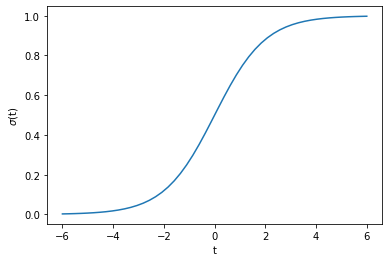

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel("t")
plt.ylabel("$\sigma$(t)")
_ = plt.plot(np.linspace(-6, 6), 1 / (1 + np.exp(-np.linspace(-6, 6))))

As our learning objective we will want to maximize the *log-likelihood* (or minimize the negative log-likelihood), which in this case is equivalent to minimizing the *cross entropy*: $$-\frac{1}{N}\sum_{1}^{N}y^i\ln(p^i) + (1-y^i)\ln(1-p^i),$$ where $p^i=\sigma(\mathscr{l})=\sigma(\theta^T x + b)$. We will be optimizing this objective via gradient descent.

So, to recap:

- calculate the logit $\mathscr{l}=\theta^T x + b$,
- calculate $\sigma(\mathscr{l})$, i.e. the predicted probability for a given example,
- calculate the cross entropy loss,
- perform gradient descent on parameters $\theta$ and $b$.

## Multinomial logistic regression

In the multinomial case (i.e. where we want to predict a discrete variable with multiple values) we will create $K$ linear predictors instead of one, where $K$ is the number of classes. We can accomplish this by replacing the parameter vector $\theta$ with a matrix $\theta \in \mathbb{R}^{D\times K}$, where the $i$-th row corresponds to the $i$-th predictor. Then $\mathscr{l}=x\theta^T \in \mathbb{R}^K$ (this is also called the logit in machine learning, though that's not exactly true from a mathematical point of view).

The logistic function gets replaced by $\mathtt{softmax}\colon\mathbb{R}^K \rightarrow \mathbb{R}^K$ (perhaps more precisely [*softargmax*](https://en.wikipedia.org/wiki/Softmax_function)): $$\mathtt{softmax}(\mathscr{l})_i = p_i = \frac{e^{\mathscr{l}_i}}{\sum_{k=1}^K e^{\mathscr{l}_k}}$$

The cost function is (again) cross entropy, i.e., for a single example:
$$-\sum_{k=1}^K \ln(\mathtt{softmax}(\mathscr{l}))_{k}\mathbb{1}(k=y)= -\ln(\mathtt{softmax}(\mathscr{l}))_{y},$$
i.e. in the output we check the dimension corresponding to the label.

## Logistic regression in PyTorch

First, we need to download the data. We'll use [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) today, which is a drop-in replacement for the original [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits.
![img](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png) The `torchvision` package is part of the PyTorch project and includes many datasets, model architectures, and image transformations.

The images are in [PIL](https://pillow.readthedocs.io/en/stable/) format, hence we need to convert them to our purposes. `torchvision` can also help with that via [transforms](https://pytorch.org/vision/0.8/transforms.html). We need to do two things:
- convert the images to PyTorch tensors,
- change their shape from 28x28 to 784 (a flat vector), as we'll just be using basic logistic regression and not e.g. convolutional neural networks.


In [23]:
from torchvision.transforms import ToTensor, Compose, Lambda
from torchvision.datasets import FashionMNIST

data = FashionMNIST(root='.', 
                    download=True, 
                    train=True, 
                    transform=Compose([ToTensor(), 
                                       Lambda(lambda x: x.view(-1))]))             

PyTorch also supplies [data loaders](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), which allow us to easily batch and shuffle the data without getting bogged down in the details every time.

In [24]:
from torch.utils.data import DataLoader

data_loader = DataLoader(data, batch_size=10, shuffle=True)

Let's see an example image.

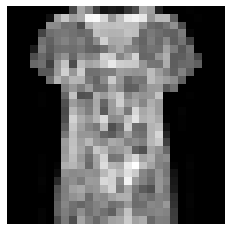

In [25]:
image_batch, label_batch = next(iter(data_loader))  # a trick to get a single batch from the dataloader

plt.axis('off')
_ = plt.imshow(image_batch[0].view(28, 28), cmap="gray")

## Task 1 (1p)

Implement (multinomial) logistic regression in PyTorch.

In [26]:
class LogisticRegression:
    def __init__(self, input_dim, output_dim, device):
        self.weights = None 
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.device = device
        
    def fit(self, data, lr=0.1, n_epochs=5):
        self.weights = torch.randn((self.input_dim, self.output_dim), requires_grad=True)
        self.bias = torch.randn(self.output_dim, requires_grad=True)
        
        data_loader = DataLoader(data, batch_size=16)
        
        losses, accs = [], []
        
        for epoch in range(n_epochs):
            for batch_idx, (images, targets) in enumerate(data_loader):
                images, targets = images.to(self.device), targets.to(self.device)
                self.weights.requires_grad = True
                self.bias.requires_grad = True
                
                predictions = self.predict_proba(images) 
                loss_val = self.cross_entropy_loss(predictions, targets)
                loss_val.backward()  # PyTorch calculates gradients for us
                accuracy = (self.predict(images) == targets).float().mean()
                
                w_grad = self.weights.grad
                b_grad = self.bias.grad
                with torch.no_grad():
                    self.weights = self.weights - lr * w_grad
                    self.bias = self.bias - lr * b_grad
                
                if batch_idx == 0:
                    losses.append(loss_val.item())
                    accs.append(accuracy.item())
        
        return losses, accs
    
    
    def softmax(self, h: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        h: torch.Tensor, shape: (batch_size, output_dim)
            Logits

        Returns
        -------
        torch.Tensor, shape: (batch_size, output_dim)
            Softmax on h
        """
        # hint: use keepdim=True when summing
        return ???
            
    def predict_proba(self, X: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        X: torch.Tensor, shape: (batch_size, input_dim)
            Images

        Returns
        -------
        torch.Tensor, shape: (batch_size, output_dim)
            Probabilities
        """
        # hint: use softmax and matrix multiplication with weights
        return ???
            
    def predict(self, X: torch.Tensor) -> torch.LongTensor:
        """
        Parameters
        ----------
        X: torch.Tensor, shape: (batch_size, K)
            Images

        Returns
        -------
        torch.Tensor, shape: (batch_size, K)
            index of X with maximum probability
        """
        # hint: use predict_proba and torch.argmax()
        return ???
    
    def cross_entropy_loss(self, y_pred: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        y_pred: torch.Tensor, shape: (batch_size, output_dim)
            Probabiities
        y: torch.Tensor, shape: (batch_size,)
            Correct classes

        Returns
        -------
        torch.Tensor, shape: (1, )
            Cross entropy loss
        """
        
        # hint: use y as indexes to retrieve appropriate columns of y_pred
        # hint: range(len(y)) in 1st dim to get all values
        return ???    

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_reg = LogisticRegression(784, 10, device)
losses, accs = log_reg.fit(data)

/home/kg/miniconda3/envs/aann/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


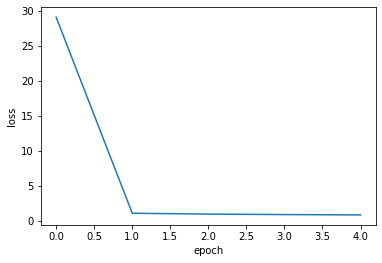

In [28]:
plt.xlabel("epoch")
plt.ylabel("loss")
_ = plt.plot(losses)

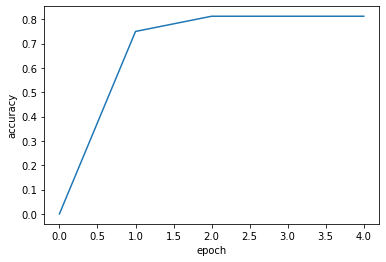

In [29]:
plt.xlabel("epoch")
plt.ylabel("accuracy")
_ = plt.plot(accs)